# Project II: Online learning with sample selection and change detection
### Task I - Offline and online learning on a small-size training set
### EP 2420 - Network Analytics

Ruihan Zhang
Nov 29, 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble, preprocessing
from sklearn.model_selection import train_test_split

print('pandas =', pd.__version__)
print('numpy =', np.__version__)

# Read data and preprocessing
X1 = pd.read_csv('./JNSM_VoD_flashcrowd_1/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
X2 = pd.read_csv('./JNSM_VoD_flashcrowd_2/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
X = pd.concat([X1,X2])
y1 = pd.read_csv('./JNSM_VoD_flashcrowd_1/Y.csv')['DispFrames']
y2 = pd.read_csv('./JNSM_VoD_flashcrowd_2/Y.csv')['DispFrames']
y = pd.concat([y1,y2]).to_numpy()
select = np.load('select_VoD.npy')

# X1 = pd.read_csv('./JNSM_KV_flashcrowd_1/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
# X2 = pd.read_csv('./JNSM_KV_flashcrowd_2/X.csv').drop(columns=['TimeStamp','Unnamed: 0'])
# X = pd.concat([X1,X2])
# y1 = pd.read_csv('./JNSM_KV_flashcrowd_1/Y.csv')['ReadsAvg']
# y2 = pd.read_csv('./JNSM_KV_flashcrowd_2/Y.csv')['ReadsAvg']
# y = pd.concat([y1,y2]).to_numpy()
# select = np.load('select_KV.npy')

del(X1,X2, y1, y2)

# standardization
X = preprocessing.scale(X, axis=0)

pandas = 1.4.4
numpy = 1.23.4


/Users/ruihanzhang/opt/anaconda3/envs/netAna/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


### Standard preprocessing pipeline for every task

- Reduce the number of features in the data set to 16 through tree-based feature selection.
- Apply one of the methods described in Project 1, Task 1 to pre-process the trace.
- Remove possible outliers.
- Use random forest regression (20 trees) for prediction and measure prediction error in NMAE.

In [13]:
a = '12asdbgr'

for x in a:
    print(x)

1
2
a
s
d
b
g
r


In [6]:
# feature selection algorithm
# regr = ensemble.ExtraTreesRegressor(n_jobs=-1)
# regr.fit(X, y)
# select = np.argsort(regr.feature_importances_)[-16:]
# np.save("select_KV", select)

In [2]:
# out-lier removal, 
T = 54 # VoD 54
X_cut = X[(np.abs(X) < T).all(axis=1)]
y_cut = y[(np.abs(X) < T).all(axis=1)]
num = X.shape[0] - X_cut.shape[0]
print('Removed outliers: ', num)
# select top features
X_cut = X_cut[:,select]
print('Selected features: ', len(select))

Removed outliers:  341
Selected features:  16


In [3]:
# our evaluating metric: Normalized Mean Absolute Error
def NMAE(y_true, y_pred):
    return abs(y_true - y_pred).mean() / abs(y_pred).mean()

### 1.1 Offline and online learning on a small-size training set

In [51]:
error = np.zeros([4,10])
for i, n in enumerate([32,128,512,2048]):
    for j in range(10):
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(X_cut, y_cut, train_size= n , test_size=1000)
        # evaluation
        regr = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        error[i,j] = NMAE(y_test, y_pred)
    print('NMAE for n = {} is:{} '.format(n,error[i,:].mean()))

NMAE for n = 32 is:0.1138614256084152 
NMAE for n = 128 is:0.10764801206257076 
NMAE for n = 512 is:0.10345155572144422 
NMAE for n = 2048 is:0.09151705104262502 


In [38]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_cut, y_cut, test_size=0.3)
# evaluation
regr = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1, verbose=1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
line = NMAE(y_test, y_pred)
print('70-30 split NMAE: ', line)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


70-30 split NMAE:  0.05056110105428017


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


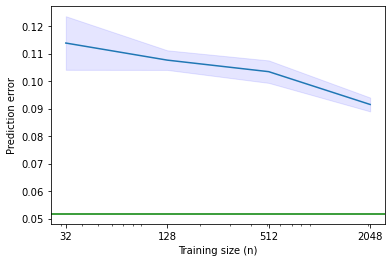

In [54]:
x = [32,128,512,2048]
y = error.mean(1)
ci = 1.96 * np.std(error,axis=1)/np.sqrt(10)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xscale("log")
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
ax.axhline(line, color='g') 
plt.xticks([32,128,512,2048],['32','128','512','2048'])
plt.ylabel('Prediction error')
plt.xlabel('Training size (n)')


### 1.2 Online learning on a small-size training set

#### Dataset preparing

In [34]:
T = 3000
iter = 1000
error = np.zeros([4,iter])

for i, n in enumerate([32,128,512,2048]):
    for j in range(iter): # number of repetitions
        # initialize
        t0 = np.random.randint(1,5001)
        X_train = X_cut[t0:t0+n, :]
        y_train = y_cut[t0:t0+n]
        # revservoir_sampling
        for t in range(n,T):
            idx = np.random.randint(0,t)
            if idx < n:
                X_train[idx,:] = X_cut[t0+t,:]
                y_train[idx] = y_cut[t0+t]
        X_test = X_cut[t0+T:,:]
        y_test = y_cut[t0+T:]

        # # random sampling
        # X_train, X_test, y_train, y_test = train_test_split(X_cut[t0:,:], y_cut[t0:], train_size= 3000 , shuffle=False)
        # X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size= n , shuffle=True)

        # evaluation
        regr = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        error[i,j] = NMAE(y_test, y_pred)
    print('train size: {}, test size: {}'.format(len(y_train), len(y_test)))
    print('NMAE for n = {} is:{} '.format(n,error[i,:].mean()))

train size: 32, test size: 31273
NMAE for n = 32 is:0.1879196585948372 
train size: 128, test size: 30913
NMAE for n = 128 is:0.1887883753868158 
train size: 512, test size: 28731
NMAE for n = 512 is:0.17590757001145937 
train size: 2048, test size: 29924
NMAE for n = 2048 is:0.1551976936523858 


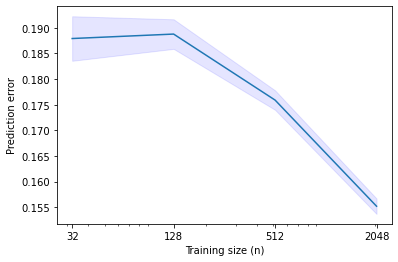

In [36]:
x = [32,128,512,2048]
y = error.mean(1)
ci = 1.96 * np.std(error,axis=1)/np.sqrt(iter)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xscale("log")
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
# ax.plot([32, 2048], [line, line])
# ax.set_ylim(0)
plt.ylabel('Prediction error')
plt.xlabel('Training size (n)')
plt.xticks(x, ['32','128','512','2048'])
plt.show()

In [16]:
np.save('T1.2_error', error)

### Task II

Online learning with periodic model re-computation

In [17]:
def rs_update(t0, index, cache):
    rgn = np.random.randint(0, index-t0) # random generated number
    if rgn < len(cache):
        cache[rgn] = index
    return cache

In [18]:
def predict(X_train, y_train, X_test):
    regr = ensemble.RandomForestRegressor(n_estimators=20, n_jobs=-1)
    regr.fit(X_train, y_train)
    return regr.predict(X_test)

In [28]:
T = 3000
error = np.zeros([4,5])

for i, n in enumerate([32,128,512,2048]):
    for j, Tc in enumerate([100,200,500,1000,2000]):
        err = []
        for _ in range(10): # number of repetitive experiments
            # initialize
            t0 = np.random.randint(0,5000)
            cache = np.arange(t0, t0+n)

            # reservoir sampling
            for t in range(t0+n,t0+T):
                cache = rs_update(t0, t, cache)
            t += 1

            # retrieve the data    
            X_train = X_cut[cache,:]
            y_train = y_cut[cache]

            # test set
            X_test = X_cut[t:t+Tc,:]
            prediction = predict(X_train, y_train, X_test)

            ### periodic training till the end
            while(t+Tc < len(y_cut)):
                # revservoir sampling
                for t in range(t,t+Tc):
                    cache = rs_update(t0, t, cache)
                # retrieve the data  
                t += 1
                X_train = X_cut[cache,:]
                y_train = y_cut[cache]
                # define test set
                X_test = X_cut[t:t+Tc,:]
                prediction = np.concatenate( [prediction, predict(X_train, y_train, X_test)] )
            err.append( NMAE(y_cut[t0+T:], prediction)) 
        # print('test size: {}'.format(len(prediction)))
        error[i,j] = sum(err) / len(err)
        print('NMAE for n = {}, Tc = {} is:{} '.format(n,Tc,error[i,j]))

NMAE for n = 32, Tc = 100 is:0.1251481401539707 
NMAE for n = 32, Tc = 200 is:0.1271308931952381 
NMAE for n = 32, Tc = 500 is:0.12973623103141696 
NMAE for n = 32, Tc = 1000 is:0.11896020008997106 
NMAE for n = 32, Tc = 2000 is:0.1303830129997219 
NMAE for n = 128, Tc = 100 is:0.12640051899504248 
NMAE for n = 128, Tc = 200 is:0.1182859153766183 
NMAE for n = 128, Tc = 500 is:0.12086228497147837 
NMAE for n = 128, Tc = 1000 is:0.11803300601077696 
NMAE for n = 128, Tc = 2000 is:0.1214202225735398 
NMAE for n = 512, Tc = 100 is:0.11339528301917574 
NMAE for n = 512, Tc = 200 is:0.11465870361774311 
NMAE for n = 512, Tc = 500 is:0.1139359677733099 
NMAE for n = 512, Tc = 1000 is:0.11872620302658418 
NMAE for n = 512, Tc = 2000 is:0.11764722012055344 
NMAE for n = 2048, Tc = 100 is:0.10842363310885747 
NMAE for n = 2048, Tc = 200 is:0.10895427104034956 
NMAE for n = 2048, Tc = 500 is:0.11324136098951314 
NMAE for n = 2048, Tc = 1000 is:0.11384179192076486 
NMAE for n = 2048, Tc = 2000 is

Text(0.5, 0, 'Training size (n)')

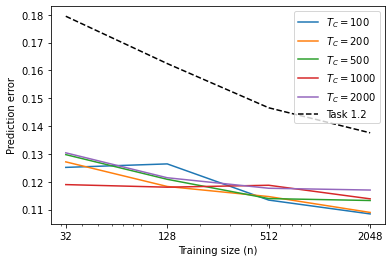

In [33]:
x = [32,128,512,2048]
y1 = error
fig, ax = plt.subplots()
ax.plot(x, y1[:,0], label='$T_C = 100$')
ax.plot(x, y1[:,1], label='$T_C = 200$')
ax.plot(x, y1[:,2], label='$T_C = 500$')
ax.plot(x, y1[:,3], label='$T_C = 1000$')
ax.plot(x, y1[:,4], label='$T_C = 2000$')
y2 = np.load('T1.2_error.npy').mean(1)
ax.plot(x, y2, 'k--', label='Task 1.2')

ax.set_xscale("log")
plt.xticks([32,128,512,2048],['32','128','512','2048'])
plt.legend()

plt.ylabel('Prediction error')
plt.xlabel('Training size (n)')

Text(0.5, 0, 'Training size (n)')

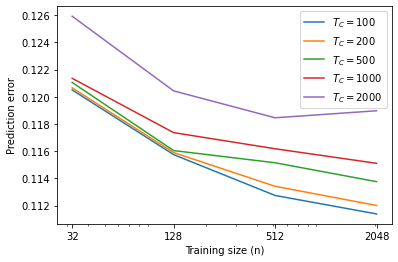

In [36]:
x = [32,128,512,2048]
y3 = np.load('T2.100times.npy')
fig, ax = plt.subplots()
ax.plot(x, y3[:,0], label='$T_C = 100$')
ax.plot(x, y3[:,1], label='$T_C = 200$')
ax.plot(x, y3[:,2], label='$T_C = 500$')
ax.plot(x, y3[:,3], label='$T_C = 1000$')
ax.plot(x, y3[:,4], label='$T_C = 2000$')
ax.set_xscale("log")
plt.xticks([32,128,512,2048],['32','128','512','2048'])
plt.legend()

plt.ylabel('Prediction error')
plt.xlabel('Training size (n)')